In [1]:
import os
import pandas as pd
from feature_functions import apply_zscore_signal
from utils.backtester import Backtester

# Directory containing asset data
asset_dir = './hist_data/crypto/kraken_4hr/'

# Initialize EV dictionary
asset_ev_dict = {}
df_dict = {}
reg_window = 5
reg_thresh = .75
# Iterate over all assets
for asset_file in os.listdir(asset_dir):
    if asset_file.endswith('.txt'):
        asset_path = os.path.join(asset_dir, asset_file)
        df = pd.read_csv(asset_path, sep=',')
        df['Date'] = pd.to_datetime(df['date'], unit='s')
        df_dict[asset_file] = df

<Figure size 1200x600 with 0 Axes>

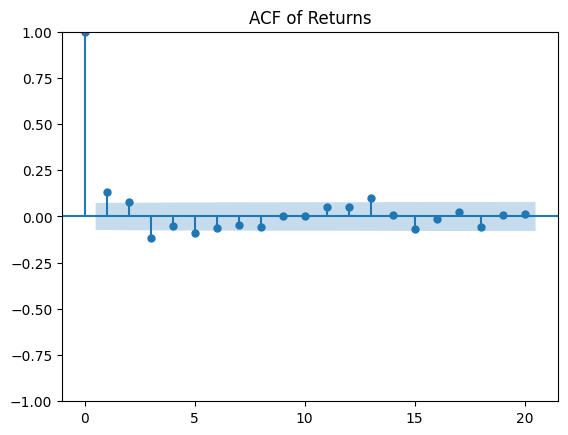

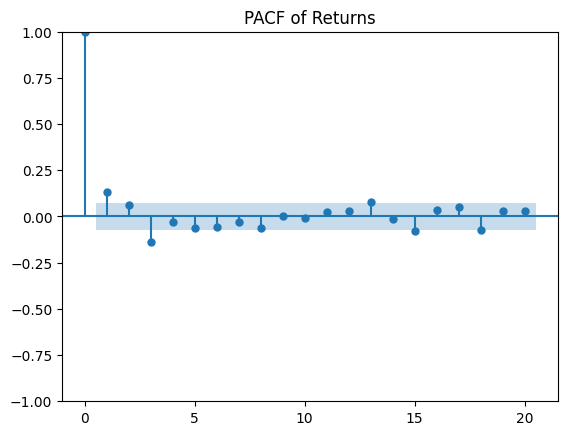

Significant lags: [0, 1, 3, 13, 15, 18]


In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt

keys = list(df_dict.keys())

test_df = df_dict[keys[0]]


returns = test_df['close'].pct_change().dropna()

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plot_acf(returns, lags=20, title="ACF of Returns")
plot_pacf(returns, lags=20, title="PACF of Returns")
plt.show()

acf_values, conf_intervals = pacf(returns, nlags=20, alpha=0.05)

# Adjust confidence intervals to be centered at zero
conf_intervals_zero = [(value - conf[0], conf[1] - value) for value, conf in zip(acf_values, conf_intervals)]

# Check significance
significant_lags = []
for lag, (value, conf) in enumerate(zip(acf_values, conf_intervals_zero)):
    lower_bound, upper_bound = -conf[0], conf[1]  # Centered at zero
    if value < lower_bound or value > upper_bound:
        significant_lags.append(lag)

print("Significant lags:", significant_lags)



In [ ]:
from statsmodels.tsa.stattools import acf, pacf

# Parameters
window_size = 50  # Size of the rolling window
nlags = 10        # Number of lags to compute

# Initialize rolling ACF/PACF values
rolling_acf = []
rolling_pacf = []

# Compute rolling ACF/PACF
for i in range(window_size, len(returns)):
    window_data = returns[i-window_size:i]  # Use only past data within the window
    # Compute ACF and PACF for the current window and skip lag = 0
    acf_values = acf(window_data, nlags=nlags, fft=True)[1:]
    pacf_values = pacf(window_data, nlags=nlags)[1:]
    rolling_acf.append(acf_values)
    rolling_pacf.append(pacf_values)

# Convert to DataFrame for easier handling
acf_df = pd.DataFrame(rolling_acf, columns=[f'acf_lag_{lag}' for lag in range(nlags)])
pacf_df = pd.DataFrame(rolling_pacf, columns=[f'pacf_lag_{lag}' for lag in range(nlags)])

print(acf_df.head())
print(pacf_df.head())

   acf_lag_0  acf_lag_1  acf_lag_2  acf_lag_3  acf_lag_4  acf_lag_5  \
0  -0.226618   0.287692  -0.355145   0.023653  -0.102662   0.091736   
1  -0.155594   0.271562  -0.264006  -0.111187  -0.107231   0.040629   
2  -0.146421   0.291698  -0.262144  -0.086892  -0.140889   0.032477   
3  -0.143897   0.277869  -0.278889  -0.084095  -0.176862   0.086705   
4  -0.117902   0.216045  -0.316697  -0.146332  -0.160033  -0.020073   

   acf_lag_6  acf_lag_7  acf_lag_8  acf_lag_9  
0  -0.029180   0.019520  -0.007431  -0.006848  
1  -0.024951   0.010208   0.005749  -0.028176  
2  -0.034559   0.006377   0.002300  -0.027362  
3  -0.036385   0.022808  -0.001814  -0.025174  
4   0.183303   0.043022   0.073496  -0.028750  
   pacf_lag_0  pacf_lag_1  pacf_lag_2  pacf_lag_3  pacf_lag_4  pacf_lag_5  \
0   -0.231242    0.260115   -0.301864   -0.176472    0.047475    0.024557   
1   -0.158769    0.264332   -0.227036   -0.279231   -0.030083    0.096341   
2   -0.149409    0.287957   -0.226997   -0.258654   -0